In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import imageio
import scipy.io as spio
import cv2
from numpy.linalg import det, inv
from scipy.spatial import Delaunay
import matplotlib.image as mpimg
import dlib

%matplotlib inline
plt.style.use('default')

Step 0: Read images

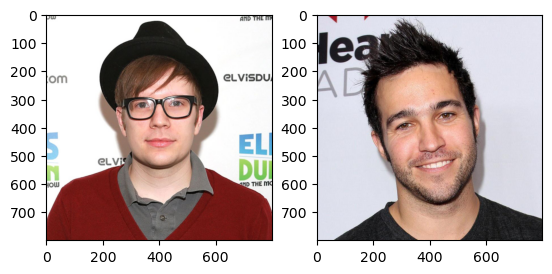

In [4]:
# the follow images are members of my favourite band Fall Out Boy
image1 = plt.imread("Orifaces\\patrick.jpg")
image2 = plt.imread("Orifaces\\pete.jpg")
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.imshow(image2)

# I used step_num = 50 to generate 50 but the aip file submitted can`t exceed 100Mb so I changed it to
# 25 to generate intermediate images submitted.
# step_num = 50
step_num = 25

Step 1: Find some corresponding face landmarks between start and end images and display them

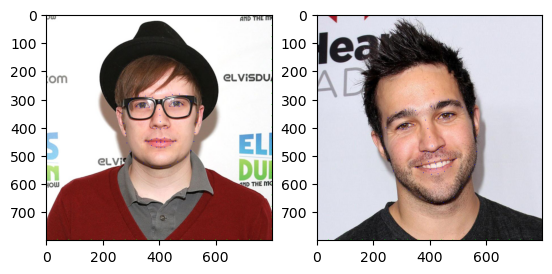

In [6]:
# detector detect the area of our face，predictor predict 68 keypoints in the area
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def get_landmarks_with_edges(image):
    img_show = image.copy()
    landmarks = []
    height, width = image.shape[:2]

    # set landmarks on face
    # one img -> one rectangle
    detections = detector(image, 1)
    # print(detections)
    for k, d in enumerate(detections):
        shape = predictor(image, d)
        # print(d)
        for i in range(0, 68):
            x = shape.part(i).x
            y = shape.part(i).y
            landmarks.append((x, y))
            cv2.circle(img_show, (x, y), 1, (0, 0, 255), -1)

    # set landmarks on the edge of our images
    edge_distance = 40
    for x in range(0, width, edge_distance):
        landmarks.append((x, 0))
        cv2.circle(img_show, (x, 0), 1, (0, 255, 0), -1)
        landmarks.append((x, height - 1))
        cv2.circle(img_show, (x, height - 1), 1, (0, 255, 0), -1)
    for y in range(0, height, edge_distance):
        landmarks.append((0, y))
        cv2.circle(img_show, (0, y), 1, (0, 255, 0), -1)
        landmarks.append((width - 1, y))
        cv2.circle(img_show, (width - 1, y), 1, (0, 255, 0), -1)

    return landmarks, img_show

landmarks1, image1_with_landmarks = get_landmarks_with_edges(image1)
landmarks2, image2_with_landmarks = get_landmarks_with_edges(image2)

plt.subplot(1, 2, 1)
plt.imshow(image1_with_landmarks)
plt.subplot(1, 2, 2)
plt.imshow(image2_with_landmarks)


Step 2:  Create a triangulation and visualise it.

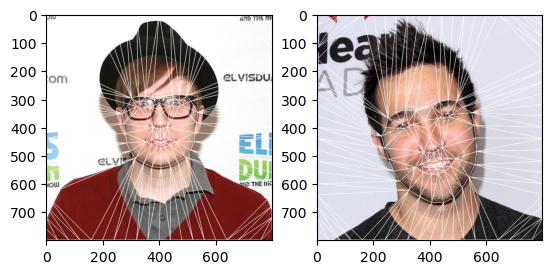

In [8]:
# draw the triangles using given triangle indices
def draw_delaunay(img, points, triangles, color=(255, 255, 255)):
    img_show = img.copy()
    for tri in triangles:
        pt1 = (int(points[tri[0]][0]), int(points[tri[0]][1]))
        pt2 = (int(points[tri[1]][0]), int(points[tri[1]][1]))
        pt3 = (int(points[tri[2]][0]), int(points[tri[2]][1]))

        cv2.line(img_show, pt1, pt2, color, 1, cv2.LINE_AA, 0)
        cv2.line(img_show, pt2, pt3, color, 1, cv2.LINE_AA, 0)
        cv2.line(img_show, pt3, pt1, color, 1, cv2.LINE_AA, 0)
    return img_show

# set traingles for the first image
# (and using those indexes later on the second image to get traingles for the second image)
delaunay_triangles1 = Delaunay(landmarks1)

# visualize
image1_show = draw_delaunay(image1, landmarks1, delaunay_triangles1.simplices)
image2_show = draw_delaunay(image2, landmarks2, delaunay_triangles1.simplices)

plt.subplot(1, 2, 1)
plt.imshow(image1_show)
plt.subplot(1, 2, 2)
plt.imshow(image2_show)
plt.show()

# get the triangles indexes
delaunay_triangles1 = delaunay_triangles1.simplices
# print(delaunay_triangles1)

Step3: Create the intermediate image coordinates

In [9]:
def interpolate_points(p1, p2, steps = step_num):
    interpolated_points = np.zeros((steps, p1.shape[0], 3, 2), dtype=np.float32)
    
    for t in range(p1.shape[0]):
        for v in range(3):
            # 对x坐标进行线性插值
            interpolated_points[:, t, v, 0] = np.linspace(p1[t, v, 0], p2[t, v, 0], num=steps)
            # 对y坐标进行线性插值
            interpolated_points[:, t, v, 1] = np.linspace(p1[t, v, 1], p2[t, v, 1], num=steps)
            
    return interpolated_points

# get the actual triangle vertices` coordnates
triangles1 = np.array([[landmarks1[vertex] for vertex in triangle] for triangle in delaunay_triangles1])
triangles2 = np.array([[landmarks2[vertex] for vertex in triangle] for triangle in delaunay_triangles1])

interpolated_triangles = interpolate_points(triangles1, triangles2)
print(interpolated_triangles.shape)

(25, 213, 3, 2)


Step4: For every pair of corresponding triangles, take the 3 pairs of corresponding vertices and estimate an Affine warp.

In [14]:
# add a small random perturbation prevents the three points of the triangle from being collinear
def perturb_points(points, perturbation_scale=1e-10):
    return points + np.random.uniform(-perturbation_scale, perturbation_scale, points.shape)

#compute affine transformation matrix
def compute_affine_transform(begin,end):
    max_attempts = 10
    for attempt in range(max_attempts):
        A = np.array([
            [begin[0][0], begin[0][1], 1, 0, 0, 0],
            [0, 0, 0, begin[0][0], begin[0][1], 1],
            [begin[1][0], begin[1][1], 1, 0, 0, 0],
            [0, 0, 0, begin[1][0], begin[1][1], 1],
            [begin[2][0], begin[2][1], 1, 0, 0, 0],
            [0, 0, 0, begin[2][0], begin[2][1], 1]
        ])
        B = np.array([end[0][0], end[0][1], end[1][0], end[1][1], end[2][0], end[2][1]])

        # whether A is singular(indicating the three points of the triangle are collinear)
        if np.linalg.det(A) != 0:
            # Solve the linear equation A * X = B for X
            X = np.linalg.solve(A, B)
            # print(X.shape)
            X = X.reshape(2, 3)
            return X
        else:
            begin = perturb_points(np.array(begin))
    
    raise ValueError("Unable to compute an affine transform due to collinear points after several attempts.")


Step5: Get all pixels in the current triangle area

In [11]:
def is_point_in_triangle(pt, tri):
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
    b1 = sign(pt, tri[0], tri[1]) < 0.0
    b2 = sign(pt, tri[1], tri[2]) < 0.0
    b3 = sign(pt, tri[2], tri[0]) < 0.0
    return ((b1 == b2) and (b2 == b3))

def get_triangle_pixels(triangle):
    pixels = []
    min_x = int(min([v[0] for v in triangle]))
    max_x = int(max([v[0] for v in triangle]))
    min_y = int(min([v[1] for v in triangle]))
    max_y = int(max([v[1] for v in triangle]))
    
    for x in range(min_x, max_x + 1):
        for y in range(min_y, max_y + 1):
            if is_point_in_triangle((x, y), triangle):
                pixels.append((x, y))
    return pixels


Step6: Map all corresponding points between the triangles.

In [12]:
def bilinear_interpolate(img, y, x):
    h, w, c = img.shape
    x0, y0 = int(x), int(y)
    x1, y1 = min(x0 + 1, w - 1), min(y0 + 1, h - 1)
    
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)
    return wa * img[y0, x0] + wb * img[y1, x0] + wc * img[y0, x1] + wd * img[y1, x1]

# apply inverse affine transform(trans pixel coordinate from intermediate image to image1)
def apply_inverse_affine_transform(pixels, affine_transform):
    matrix = np.array(affine_transform)
    augmented_matrix = np.vstack([matrix, [0, 0, 1]])
    inverse_matrix = np.linalg.inv(augmented_matrix)[:2, :]
    transformed_pixels = []
    for pixel in pixels:
        homogeneous_coord = np.array([pixel[0], pixel[1], 1])
        new_coord = inverse_matrix @ homogeneous_coord
        transformed_pixels.append(new_coord)
    return transformed_pixels

# apply affine transform(trans pixel coordinate from intermediate image to image2)
def apply_affine_transform(pixels, affine_transform):
    affine_transform = np.array(affine_transform)
    transformed_pixels = []
    for pixel in pixels:
        homogeneous_coord = np.array([pixel[0], pixel[1], 1])
        new_coord = affine_transform @ homogeneous_coord
        # discard the last element of homogeneous coordinates
        transformed_pixels.append(new_coord[:2])
    return transformed_pixels



Step7: Apply blending.

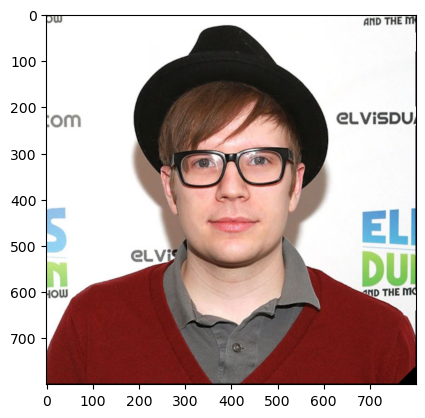

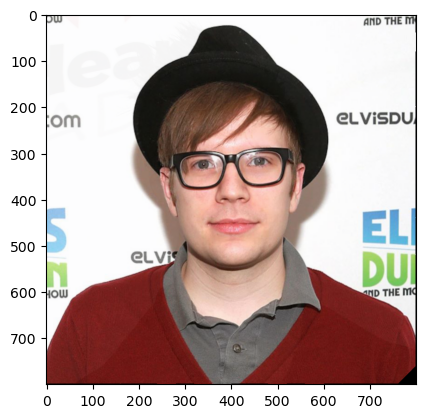

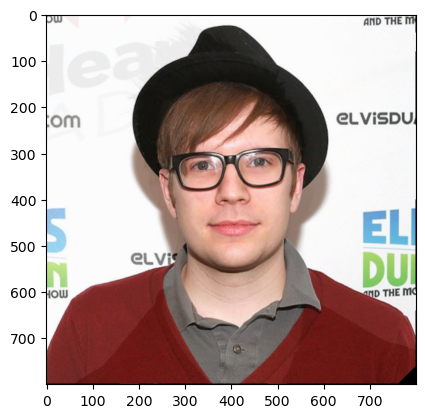

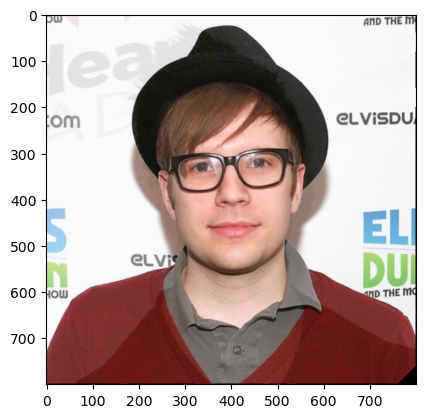

In [15]:
intermediate_images=[]
intermediate_images.append(image1)
save_dir = "result_images" 

for step in range(step_num):
    intermediate_image = np.zeros(image1.shape, dtype=image1.dtype)
    w = step * 1. / step_num

    for i in range(len(delaunay_triangles1)):
        tri_intermediate = interpolated_triangles[step][i]
        # print(tri_intermediate)
        triangle_pixels = get_triangle_pixels(tri_intermediate) 
        
        # calculate the contribution of img1 to the current image
        # compute affine transform
        affine_transform = compute_affine_transform(triangles1[i], tri_intermediate)
        # get the color of the pixel on img1 corresponding to the current point through inverse affine transformation
        src_pixels = apply_inverse_affine_transform(triangle_pixels,affine_transform)
        
        # calculate the contribution of img2 to the current image
        # compute affine transform
        affine_transform2 = compute_affine_transform(tri_intermediate, triangles2[i])
        # get the color of the pixel on img1 corresponding to the current point through affine transformation
        dst_pixels = apply_affine_transform(triangle_pixels,affine_transform2)
        #print(src_pixels.shape)

        #for each pixel of intermediate image find the correseponding pixel`s` value in img1 and img2 using bilinear interpolation
        for i, pixel in enumerate(triangle_pixels):
            src_x, src_y = src_pixels[i][0], src_pixels[i][1]
            dst_x, dst_y = dst_pixels[i][0], dst_pixels[i][1]
            if 0 <= src_x < image1.shape[1]-1 and 0 <= src_y < image1.shape[0]-1:
                pixel_value = bilinear_interpolate(image1, src_y, src_x)
                pixel_value2 = bilinear_interpolate(image2, dst_y, dst_x)
                pixel_value = (1 - w) * pixel_value + w * pixel_value2
                intermediate_image[(int)(pixel[1]), (int)(pixel[0])] = pixel_value

    plt.imshow(intermediate_image)
    plt.show()
    intermediate_images.append(intermediate_image)

intermediate_images.append(image2)
plt.show()




Step 8: Save the images.

In [10]:
folder_path = 'outputImgs/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)


for i, image in enumerate(intermediate_images):
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image_path = os.path.join(folder_path, f'image_{i}.png')
    cv2.imwrite(image_path, image_bgr)


Step 9: Create a video with all the “in between” images. 

In [12]:
from IPython.display import Video

folder_path = 'outputImgs/'
output_folder = 'outputVideos'
output_video_path = os.path.join(output_folder, 'output_video.mp4')

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

num_images = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
with imageio.get_writer(output_video_path, mode='I', fps=10) as writer:
    for i in range(num_images):
        image_path = os.path.join(folder_path, f'image_{i}.png')
        image = imageio.imread(image_path)
        writer.append_data(image)

Video(output_video_path)